In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [3]:
import tensorflow as tf
import numpy as np
import os.path as osp

from tflearn.layers.core import fully_connected
from tflearn.layers.conv import conv_2d

from tf_lab.point_clouds.encoders_decoders import decoder_with_fc_only
from tf_lab.external.structural_pc_losses import losses
from general_tools.notebook.tf import reset_tf_graph
from tf_lab.data_sets.numpy_dataset import NumpyDataset
from geo_tool import Point_Cloud

In [4]:
import helper

from tf_lab.diff_maps.in_out import raw_data, produce_net_data,\
prep_splits_labels_for_task, produce_diff_maps, classes_of_tasks

from tf_lab.diff_maps.basic_nets import pc_net, diff_mlp_net, diff_conv_net, pc_versions
from tf_lab.diff_maps.basic_nets import Basic_Net

In [5]:
%matplotlib inline

In [6]:
top_mesh_dir = '/orions4-zfs/projects/optas/DATA/Meshes/SCAPE_8_poses/'
gt_param_f = osp.join(top_mesh_dir, 'gt_shape_params.mat')
n_pose_classes = helper.n_pose_classes

In [22]:
use_pc = False
knn = 0
arch = 'conv'
sub_member_per_class = 50
n_shapes = sub_member_per_class * n_pose_classes
val_per = 0.10
test_per = 0.15
train_per = 1.0 - (val_per + test_per)
n_pc_points = 2048
task = 'regression'
mean_norm_diffs = True

In [23]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/OUT/latent_diff_maps/experiments/SCAPE_8_poses'
synced_bases_file = osp.join(top_data_dir, '50_extract_%d_knn_50_fmapd.mat' % (knn,) )
n_cons = 40
seed = 42

In [25]:
gt_latent_params, in_pcs, pose_labels = \
raw_data(top_mesh_dir, gt_param_f, sub_member_per_class, n_pc_points)

n_classes = classes_of_tasks(task)

diff_maps = produce_diff_maps(synced_bases_file, n_cons, n_shapes)

# splits, labels = \
# prep_splits_labels_for_task(task, gt_latent_params, pose_labels, train_per, test_per, seed)

# net_data = produce_net_data(in_pcs, splits, labels, diff_maps, use_pc, mean_norm_diffs)

#TODO mixed data.

In [26]:
learning_rate = 0.005
batch_size = 50

In [38]:
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

In [ ]:
ae = PointNetAutoEncoder()

In [27]:
nn_distance, approx_match, match_cost = losses()

# Try with     n_cons = 40
def diff_reconstructor(n_cons, n_pc_points):
    with tf.variable_scope('conv_based_reconstructor'):
        feed_pl = tf.placeholder(tf.float32, shape=(None, n_cons, n_cons))
        labels_pl = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))
        layer = tf.expand_dims(feed_pl, -1)
        layer = conv_2d(layer, nb_filter=10, filter_size=3, strides=2, activation='relu')        
        layer = conv_2d(layer, nb_filter=10, filter_size=4, strides=2, activation='relu')
        net_out = decoder_with_fc_only(layer, layer_sizes=[128, n_pc_points*3], b_norm=False)
        net_out = tf.reshape(net_out, [-1, n_pc_points, 3])
    return net_out, feed_pl, labels_pl

#TODO check normalization of point-clouds
reset_tf_graph()
x_reconstr, feed_pl, labels_pl = diff_reconstructor(n_cons, n_pc_points)
cost_p1_p2, _, cost_p2_p1, _ = nn_distance(x_reconstr, labels_pl)
loss = tf.reduce_mean(cost_p1_p2) + tf.reduce_mean(cost_p2_p1)
# loss = tf.reduce_sum(tf.sqrt(cost_p1_p2) + tf.sqrt(cost_p2_p1), 1)
# loss = tf.reduce_mean(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

In [30]:
r_perm = np.random.permutation(np.arange(n_shapes))
in_pcs = in_pcs[r_perm]
diff_maps = diff_maps[r_perm]


net_data = dict()
net_data['train'] = NumpyDataset([diff_maps[:300], in_pcs[:300]])
net_data['test'] = NumpyDataset([diff_maps[301:360], in_pcs[301:360]])
net_data['val'] = NumpyDataset([diff_maps[361:], in_pcs[361:]])

max_epochs = 800

In [31]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
init = tf.global_variables_initializer()
sess = tf.Session(config=config)
sess.run(init)

In [32]:
batches_for_epoch = net_data['train'].n_examples / batch_size
n_plot = 10
for epoch in xrange(max_epochs):
    epoch_loss = 0.0
    for _ in xrange(batches_for_epoch):
        feed, gt = net_data['train'].next_batch(batch_size)
        feed_dict = {feed_pl:feed, labels_pl:gt}
        _, l = sess.run([train_step, loss], feed_dict)
        epoch_loss += l
    if epoch % n_plot == 0:        
        print epoch, epoch_loss / float(batches_for_epoch),
        
        feed, gt = net_data['val'].next_batch(net_data['val'].n_examples)
        feed_dict = {feed_pl:feed, labels_pl:gt}
        l = sess.run(loss, feed_dict)
        print l

0 0.188749284173 0.0275981
10 0.00697724583248 0.00724465
20 0.00689318869263 0.00712382
30 0.00706852693111 0.00722108
40 0.00683817453682 0.00703237
50 0.00678829414149 0.00708452
60 0.00673958201272 0.00704244
70 0.00671238917857 0.00693348
80 0.00663488839443 0.00680234
90 0.0065232742733 0.00677264
100 0.00629173281292 0.00642995
110 0.00615662041431 0.00636311
120 0.00615207105875 0.00624492
130 0.00613928105061 0.00624662
140 0.00608071257981 0.00624065
150 0.00608334255715 0.00627571
160 0.00598271617976 0.00610268
170 0.00566732371226 0.00577288
180 0.00515267858282 0.00533289
190 0.00476914085448 0.00494292
200 0.00438670107784 0.00459632
210 0.00399017427117 0.004252
220 0.00344847821786 0.00365178
230 0.00279030149492 0.00298807
240 0.0023320861704 0.00250498
250 0.00197090030027 0.00210799
260 0.00173789245309 0.00191989
270 0.00153579372757 0.00166759
280 0.00142725372765 0.00155844
290 0.00129390614651 0.0014541
300 0.00123030358615 0.00138099
310 0.00115419179201 0.0013

KeyboardInterrupt: 

In [33]:
feed, gt = net_data['test'].next_batch(batch_size)
feed_dict = {feed_pl:feed, labels_pl:gt}
recon = sess.run(x_reconstr, feed_dict)

12


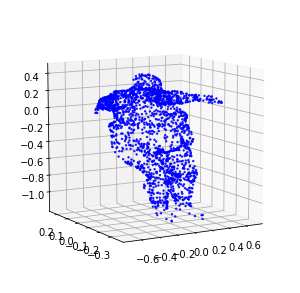

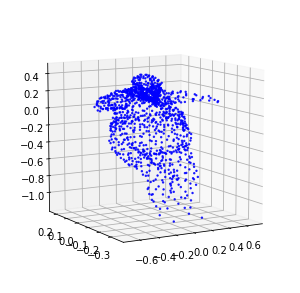

In [37]:
rid = np.random.randint(50)
print rid
Point_Cloud(gt[rid]).plot(in_u_sphere=False);
Point_Cloud(recon[rid]).plot(in_u_sphere=False);